# SocialStock Data Analysis

This notebook has the following objectives:

1) find equilibrium time in IncDistr vs time plot <br>
2) visualize the social network each day of the simulation <br>
3) show histogram about opinion sum and companies' indexes <br>
4) find equilibrium time in opinions vs time plot

In [194]:
# SETTING THE PARAMETERS
companies=3
op_range=5
users=100

gamma = 2.5

In [187]:
# IMPORTING LIBRARIES
import networkx as nx
import pandas as pd

import numpy as np
#from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

In [188]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1) Equilibrium time in IncDistr vs time plot 

In [196]:
def read_function(data):

    feDays = 0
    with open(data + 'Int2.txt', 'r') as f:
        lines = f.read().splitlines()
        last_line = lines[-1]
        feDays = int(last_line.split(":")[0])   

    fail = open( data + "Int2.txt")
    tit = fail.readline()
    lines = fail.readlines()
    fail.close()

    day_user = []
    day_user_incl = [[0]*feDays]*users
    Deg = [0]*users

    for l in lines :
        line = l.split(":")

        try : 
            day = int(line[0])
            user = int(line[1])
            incl = int(line[2])
            deg = int(line[3])

            if [True]*4 == [isinstance(i, int) for i in [day, user, incl, deg]]:  
                c = [day,user]
                day_user.append(c)
                day2 = day -1
                try : 
                    day_user_incl[user][day2] = incl
                except  IndexError :
                    print("IndexError")
                    print(user,day2)
                    print("\n")

                Deg[user] = deg 

        except ValueError :
            print("unreadable exception")
            print(line)
            print("\n")

    fail = open( data + "Int2.txt", 'a')

    for d in range(feDays) : 
        for u in range(users) :  
             if [d +1,u] not in day_user :
                incl = day_user_incl[u][(d+2)%feDays]
                deg = Deg[u]
                callout = [i for i in (np.random.choice(users , deg , replace = False))]
                string = '\n' +str(d+1)+':'+str(u)+':'+str(incl)+':'+str(deg)+':'+str(callout)
                fail.write(string)
    fail.write('\n')
    fail.close()
    
    fail = open( data + "Int2.txt")
    tit = fail.readline()
    X = []
    nn = {}

    for l in fail.readlines() :
        line = l.split(":")
        line[0:4] = [int(i) for i in line[0:4]]
        line[4] = line[4][1:-2].split(", ")

        if line[4][0] == "" :
            line[4] = []
        else : 
            line[4] = [int(i) for i in line[4]]
            nn[ (line[0],line[1]) ] = line[4]

        X.append(line[0:4])


    X = np.array(X)
    X = pd.DataFrame(X) 

    tit = tit.split("-")[:-1]
    X.columns = tit
    X=X.sort_values(["uDays" , "ind"])
    
    return X, nn

In [201]:
# IMPORTING DATASET FOR 1) AND 2)
from pathlib import Path
d = Path().resolve().parent 
data = str(d) + "/data/c"+str(companies)+"r"+str(op_range)+"n"+str(users)
print(data)
X, nn = read_function(data)

/Users/Cinus/University/Magistrale_Sistemi_Complessi_Torino/MAS/GitHub/SocialStock/data/c3r5n100


ValueError: invalid literal for int() with base 10: '\n'

In [ ]:
#dataframe first day
X1 = X[X.uDays==1]
uDays = len(X.uDays.unique())
Deg = np.array(X1.sort_values("ind").deg)

In [199]:
# key : indice dello user
# value : lista con gli indici della callout list 
nearest_neighbours = {}

for d in range(uDays) :
    nearest_neighbours[d+1] = {}
    for u in range(users) :
        nearest_neighbours[d+1][u] = nn[(d+1,u)]

Text(0,0.5,'$IncDistr$')

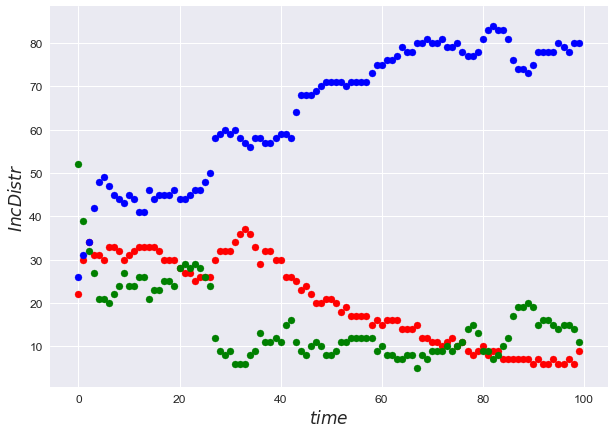

In [200]:
IncDistr = []
for d in range(uDays):
    all_incl=list(X[X.uDays==d+1].incl)
    IncDistr.append( [all_incl.count(-1), all_incl.count(0), all_incl.count(1)] )
IncDistr = np.array(IncDistr)

plt.figure(figsize=(10,7))
plt.scatter(y=IncDistr[:,0] , x=range(uDays) , color = "red" )
plt.scatter(y=IncDistr[:,1] , x=range(uDays) , color = "green")
plt.scatter(y=IncDistr[:,2] , x=range(uDays) , color = "blue")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$time$', fontsize=17)
plt.ylabel('$IncDistr$', fontsize=17)

In [ ]:
t=0
IncDistr_t=[]
for i in IncDistr:
    if( np.array_equal(i,IncDistr_t) ):
        print('Equilibrium time is '+ str(t))
        break
    else: 
        IncDistr_t=[j for j in i]
        t+=1

In [ ]:
# OPINION MATRIX

fail = open( data + ".txt")
tit = fail.readline()

Op = []

for l in fail.readlines() :
    line = (l.split(","))
    line[companies-1] = line[companies-1][:-2]
    line = [float(i) for i in line]
    Op.append(line)
    
# O is a dictionary with: (key : day) (value : opinion matrix of that day)    
O = {}
index = 0
for d in range(uDays) :
    O[d+1] = np.array(Op[index:(index + users)])
    index = index + users

## 2) Visualize Network of Day 1

In [ ]:
def Graphday(X , day) :
    G1 = nx.Graph()
    X1 = X[X.uDays == day]
    X1 = X1.sort_values(["ind"])

    for u in range(users) : 
            for n in nearest_neighbours[day][u] :
                G1.add_edge(u,n)

    pos1 = nx.circular_layout(G1)
    incols = np.array(["red","green","blue"])

    m = np.sum(O[day] , axis =1)
    for i in range(users) :
        pos1[i][0] = m[i] + np.random.normal(scale =0.2)
        pos1[i][1] += np.random.normal(scale =0.2)

    plt.figure(1,figsize=(15,12)) 
    plt.xlim( (np.min(m) -1 , np.max(m) +1) )
    nx.draw_networkx(G1,
                     node_size= X1.deg*100, 
                     pos = pos1,
                     node_color= incols[np.array(X1.incl +1)], 
                     with_labels=False,
                     width=0.1)
    
    
Graphday(X,1)
plt.show()

In [ ]:
# DEGREE DISTRIBUTION
plt.hist(X1.deg, range=(0,20))
plt.show()

## 4) Equilibrium time in sum(opinions) vs time plot 

In [ ]:
# defining dictiorary time: sum of opinions at that time
O_t={}
for i in O.keys():
    # list of vector to sum
    vec_list=[O[i][j] for j in range(users)]
    # summing vectors
    O_t[i] = np.sum( vec_list, axis=0 )
#O_t

In [ ]:
plt.figure(figsize=(10,7))
for i in range(companies):
    Y_comp=[O_t[j+1][i] for j in range(uDays)]
    plt.scatter( y=Y_comp , x=range(uDays) )

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$time$', fontsize=17)
plt.ylabel('$Opinions$', fontsize=17)

In [ ]:
t=0
for i in range(len(Y_comp)):
    #print(Y_comp[i])
    if( np.array_equal(Y_comp[i],Y_comp[i+6])):
        print('Equilibrium time is '+ str(t))
        break
    else: 
        t+=1

##### 3) Histrogram opinions - companies

In [ ]:
# CHOOSE DAY
day=1
plt.figure(figsize=(10,7))

colors=[]
for i in O_t[day]:
    if(i<0): colors.append('red')
    if(i>0): colors.append('blue')
        
# histogram
bar([i for i in range(companies)], list(O_t[day]), color=np.array(colors))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('$Cumulative-Opinion$', fontsize=17)
plt.xlabel('$Company-index$', fontsize=17)

In [ ]:
feX = pd.Series( [np.array([1,2,3]) , np.array([4,6]), np.array([4,6,4])])
feX.name = "arrays"
feX